## Imports


In [9]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from io import BytesIO
from IPython.display import Image, display
import json
sys.path.append('rtsa-decoder')

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

from rtsa_decoder.DSPStreamFileChunkSamples import DSPStreamFileChunkSamples
from rtsa_decoder.chunk_id_map import get_chunk_object
from rtsa_decoder.rtsa_decoder import get_samples_from_file
from rtsa_decoder.rtsa_processing import get_heatmap_png, get_max_hold_json

# Create a folder for plots
plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

# Create a folder for storing carrier JSON files
carrier_dir ='carriers'
os.makedirs(carrier_dir,exist_ok=True)

## Define Functions

In [10]:
def noise_threshold(noise_samples, multiple_std):
    """
    calculate oise threshold based on multiple standard deviations above the mean
    
    Parameters:
    - noise_samples: List of file names containing noise data
    - multiple_std: Multiplier for the standard deviation
    
    Returns:
    - calculated noise threshold
    """
    concetanted_array=[]
    for file in noise_samples:
        with open(os.path.join("Files_for_SW_Dev_application",file), "rb") as file_object:
            samples = get_samples_from_file(file_object)
            matrix = samples.samples
            concetanted_array.append(matrix)
    concetanted_array=np.concatenate(concetanted_array)
    mean=np.mean(concetanted_array)
    std = np.std(concetanted_array)

    threshold = mean + multiple_std * std
    return threshold

def plot_max_hold(max_hold, file_name):
    plt.figure(figsize=(10, 6))
    plt.plot(max_hold)
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title(f'{file_name}')
    plt.savefig(os.path.join(plots_dir, file_name))
    plt.close()
    display(Image(filename=os.path.join(plots_dir, file_name)))

def plot_gradients(gradients, file_name):
    plt.figure(figsize=(10, 6))
    plt.plot(gradients)
    plt.xlabel('Column Index')
    plt.ylabel('Gradient')
    plt.title(f'{file_name}')
    plt.savefig(os.path.join(plots_dir, file_name))
    plt.close()
    display(Image(filename=os.path.join(plots_dir, file_name)))

def plot_heatmap(matrix,file_name):
    plt.figure(figsize=(10, 6))
    plt.imshow(matrix, aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar(label='Value')
    plt.title(f'{file_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Time')
    plt.savefig(os.path.join(plots_dir, file_name))
    plt.close()
    display(Image(filename=os.path.join(plots_dir, file_name)))
 

def smooth(array):
    """
    Smooth an array by summing two adjacent values to make adjacent gradients more detectable
    
    Parameters:
    - array: 1D array of gradient values
    
    Returns:
    - smoothed_array: Smoothed 1D array
    """
 
    smoothed_array = array.copy()
   
    for i in range(len(array) - 1):
        if array[i] != 0 and array[i + 1] != 0:
            new_value =array[i]+array[i+1]  
            smoothed_array[i + 1] = new_value  
            smoothed_array[i] = 0  

    return smoothed_array

def detect_carriers(gradients):
    """
    Detect carriers based on the gradients by checking if two min or max gradients are in the possible frequency span of a carrier 
    
    Parameters:
    - gradients: Array of gradient values
    
    Returns:
    - carriers: List of tuples containing start and end indices of detected carriers
    """

    carriers = []
    carrier_ranges = [115,116,117,118]
    
    
    while len(gradients[gradients!=0]>1):

        max_gradient_index = np.argmax(gradients)
        min_gradient_index = np.argmin(gradients)
        found_carrier = False

        for carrier_range in carrier_ranges:
            if max_gradient_index >= carrier_range and gradients[max_gradient_index-carrier_range] !=0:
                carriers.append((max_gradient_index-carrier_range,max_gradient_index))
                gradients[max_gradient_index-carrier_range:max_gradient_index]=0
                found_carrier = True
                break
            if max_gradient_index+carrier_range <=len(gradients) and gradients[max_gradient_index+carrier_range]!=0:
                carriers.append((max_gradient_index,max_gradient_index+carrier_range))
                gradients[max_gradient_index:max_gradient_index+carrier_range]=0
                found_carrier = True
                break
        for carrier_range in carrier_ranges:
            if min_gradient_index >= carrier_range and gradients[min_gradient_index - carrier_range]!=0:
                carriers.append((min_gradient_index-carrier_range,min_gradient_index))
                gradients[min_gradient_index-carrier_range:min_gradient_index]=0
                found_carrier = True
                break
            if min_gradient_index+carrier_range <= len(gradients) and gradients[min_gradient_index+carrier_range]!=0:
                carriers.append((min_gradient_index,min_gradient_index+carrier_range))
                gradients[min_gradient_index:min_gradient_index+carrier_range]=0
                found_carrier = True
                break
        if not found_carrier:
            break
    return carriers

def get_time_and_max_power (start_index,end_index,matrix,threshold):
    """
    Get time range and max power of the carrier.
    
    Parameters:
    - start_index: Frequency Start index of the carrier
    - end_index: Frequency End index of the carrier
    - matrix: 2D array of data from file_object
    - threshold: Noise threshold value
    
    Returns:
    - lower_percentile: Start time index of the carrier
    - upper_percentile: End time index of the carrier
    - max_power_value: Maximum power value of the carrier
    """
   
    high_value_matrix = np.where(matrix > threshold, matrix, 0) 
    filtered_matrix = high_value_matrix[:, start_index:end_index+1]
    non_zero_y_indices = np.where(filtered_matrix != 0)[0]
    sorted_indices = np.sort(non_zero_y_indices)
    std_dev_sorted_indices= np.std(sorted_indices)
    
    lower_percentile = int(np.percentile(sorted_indices, std_dev_sorted_indices) ) 
    upper_percentile = int(np.percentile(sorted_indices, 100-std_dev_sorted_indices))
    
    max_power_matrix =high_value_matrix[lower_percentile:upper_percentile,start_index:end_index]
    max_power_values =max_power_matrix[np.nonzero(max_power_matrix)]
    max_power_value = np.max(max_power_values)

    return lower_percentile, upper_percentile, max_power_value

        


## Data Loading

In [11]:

carriers_samples = [
    'DOR_KU#1_1401085380.rtsa',
    'DOR_KU#1_1401087296.rtsa',
    'DOR_KU#1_1401088148.rtsa',
    'DOR_KU#1_1401088878.rtsa',
    'DOR_KU#1_1401090450.rtsa',
    'DOR_KU#1_1401087211.rtsa',
    'DOR_KU#1_1401091686.rtsa',
    'DOR_KU#1_1401093321.rtsa',
    'DOR_KU#1_1401090840.rtsa'   #I am not sure if this file counts as noise or possible carrier.

]

noise_samples =[
    'DOR_KU#1_1401049243.rtsa',
    'DOR_KU#1_1401086292.rtsa',
    'DOR_KU#1_1401089776.rtsa',
    'DOR_KU#1_1401089946.rtsa',
    'DOR_KU#1_1401090703.rtsa',
    'DOR_KU#1_1401086410.rtsa'
    
]


## Main


get_samples_array: Number of samples: 7380000
get_samples_array: Number of sweeps: 90.0


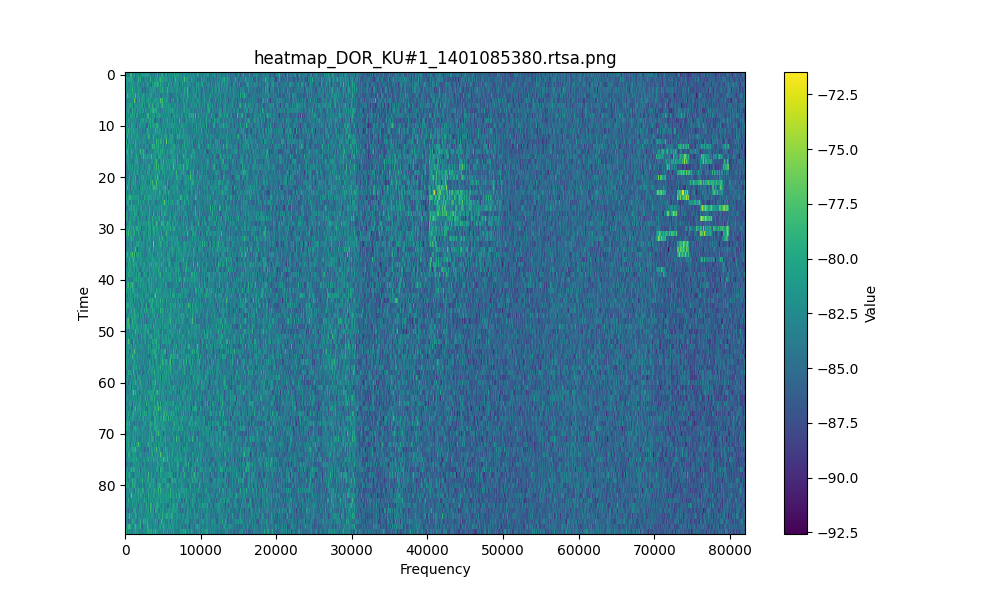

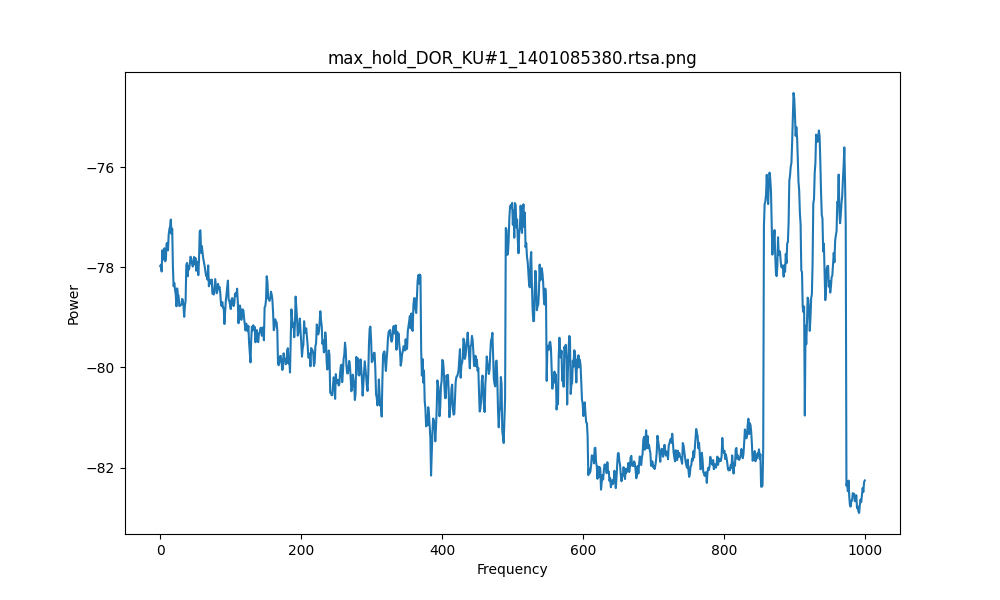

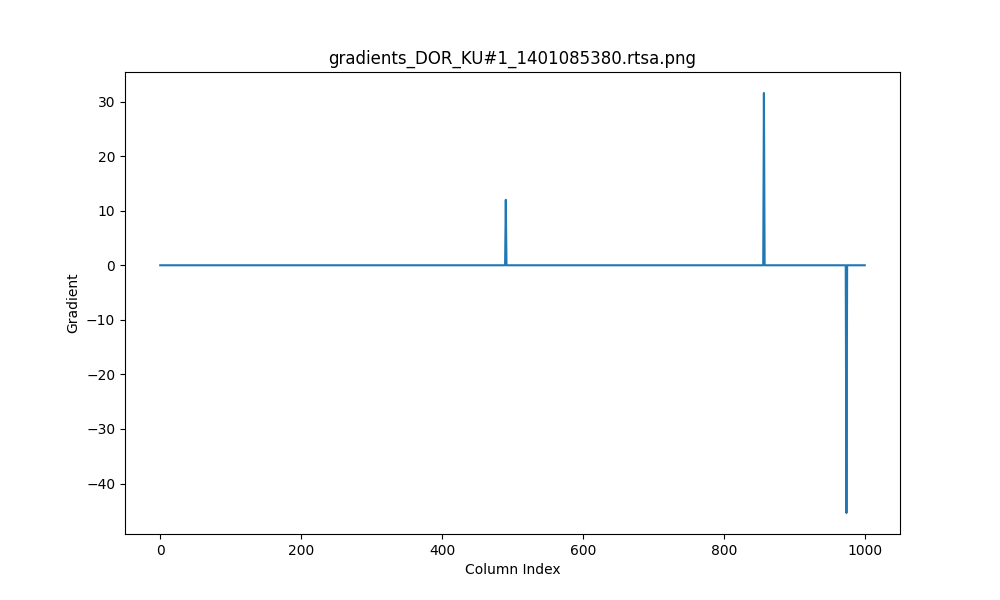

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 6724000
get_samples_array: Number of sweeps: 82.0


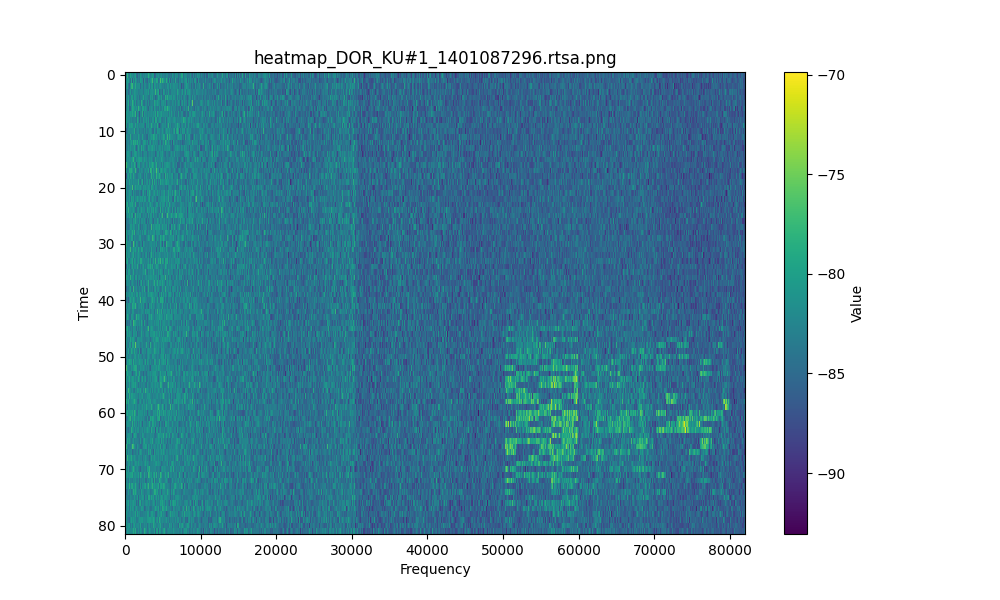

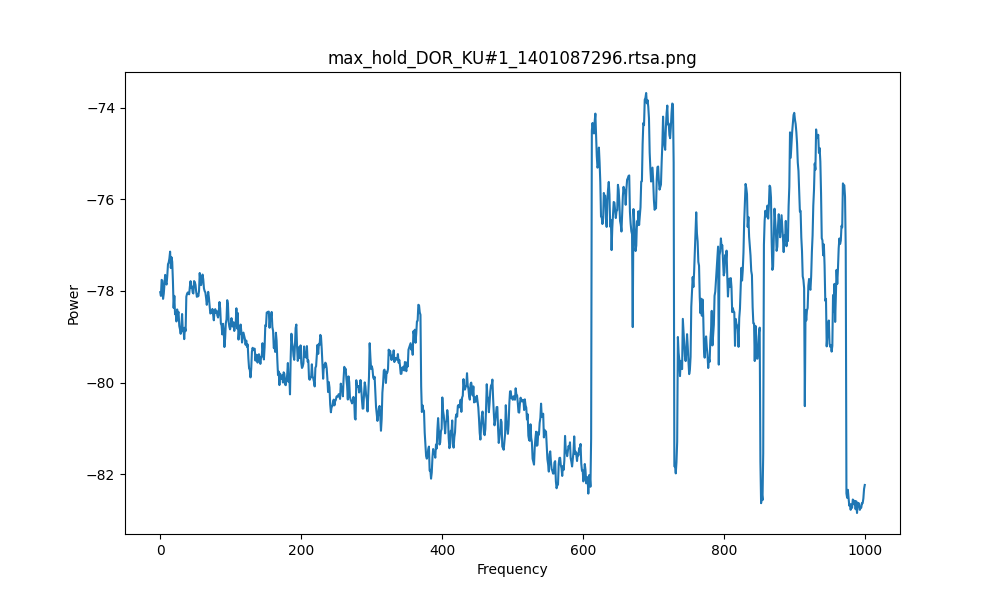

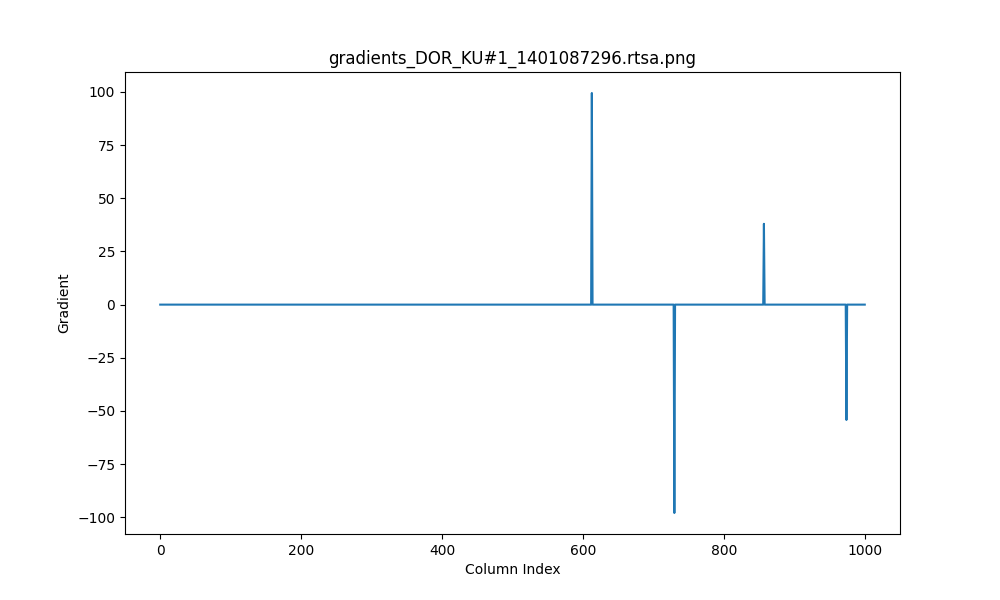

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of sam

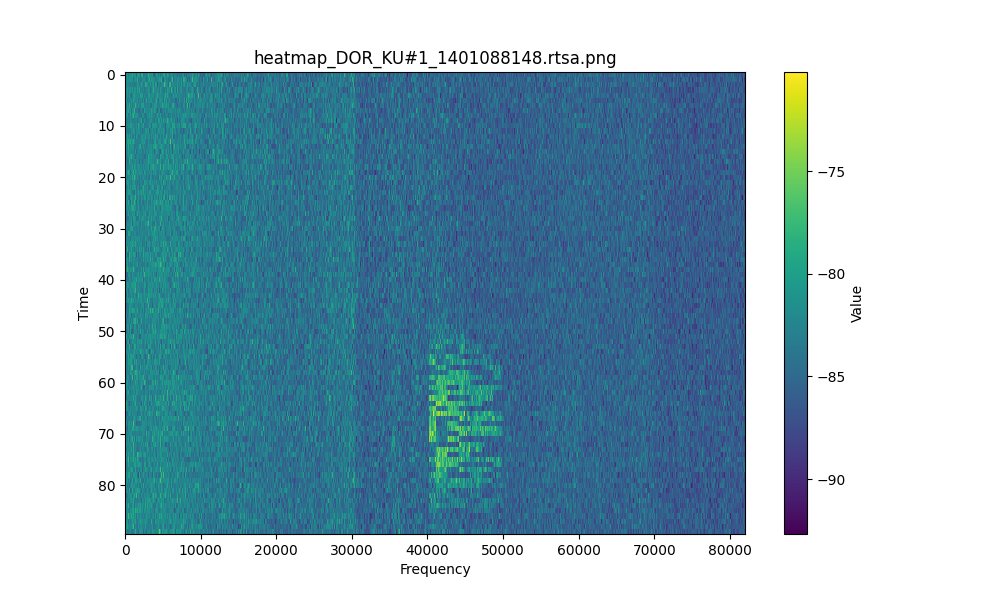

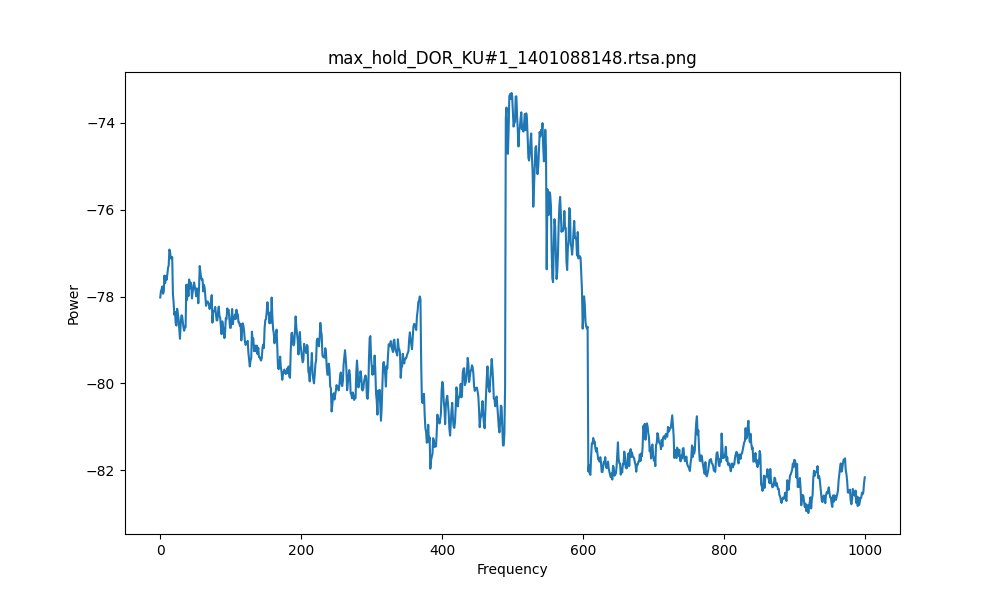

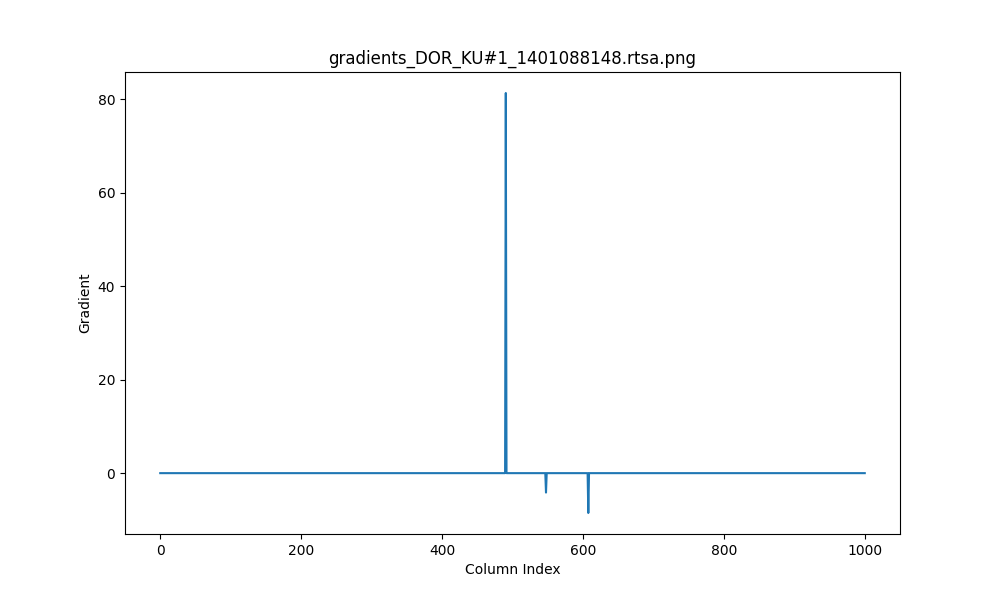

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0


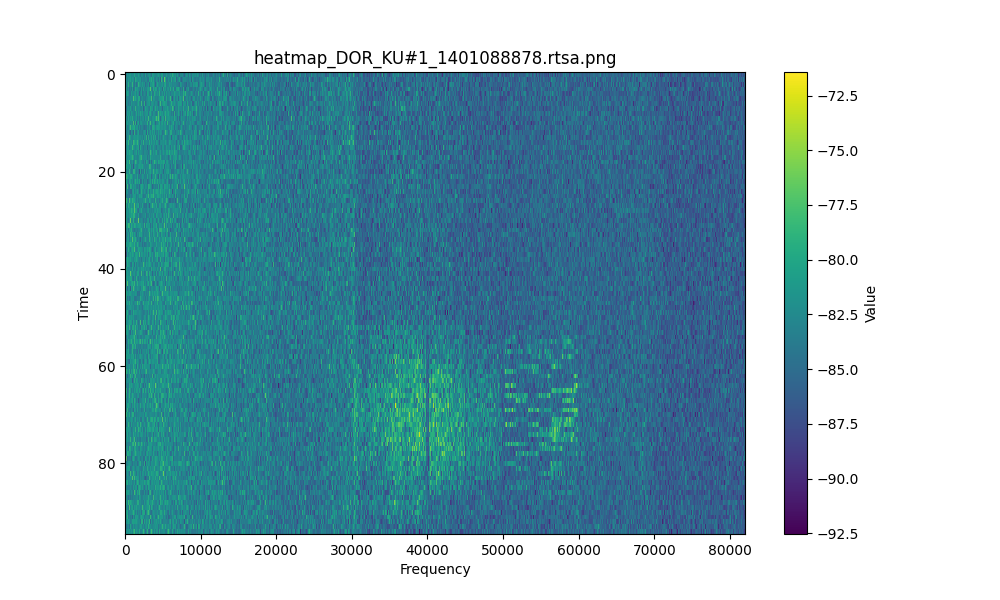

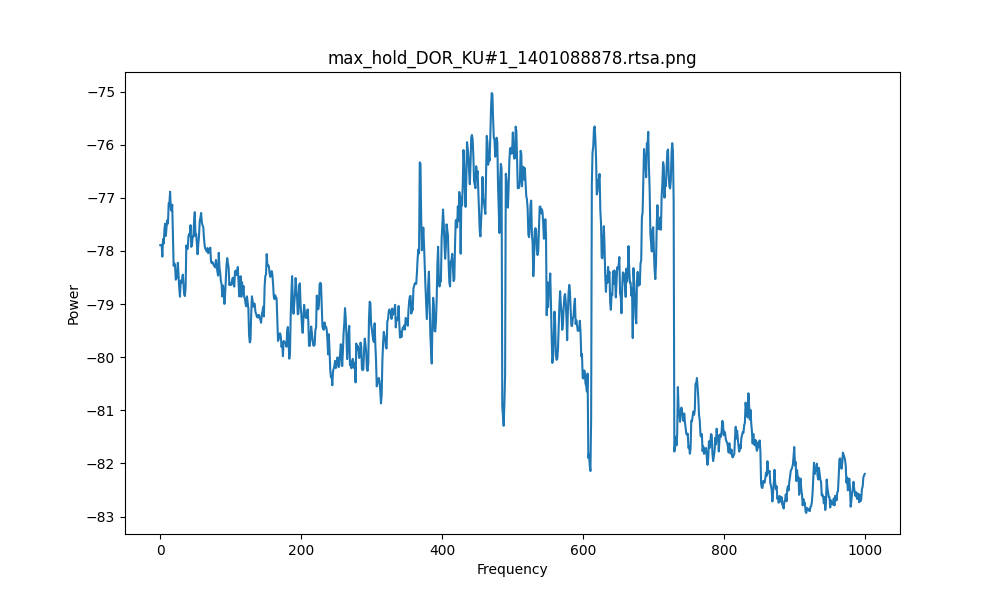

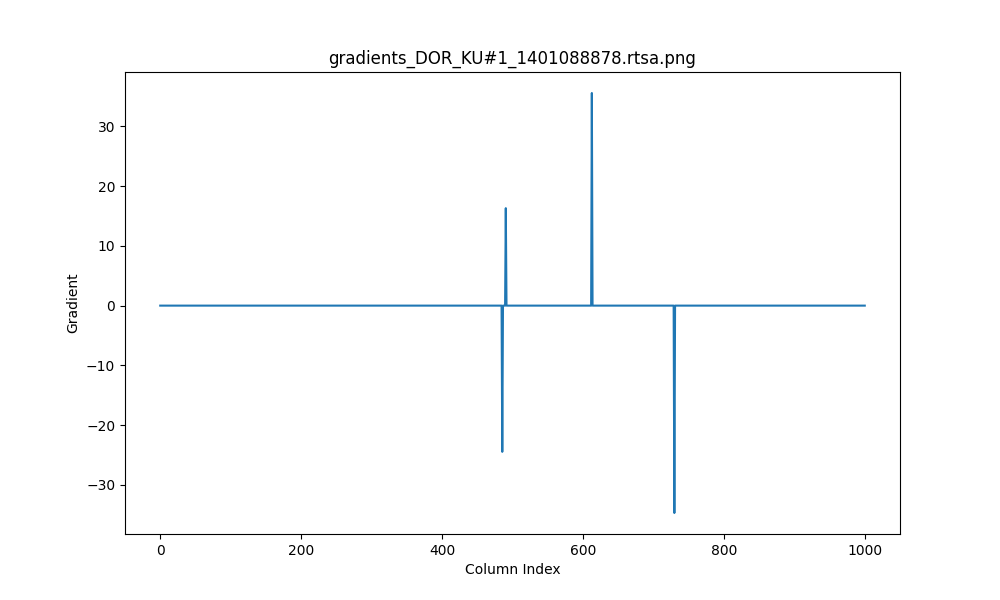

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 7462000
get_samples_array: Number of sweeps: 91.0


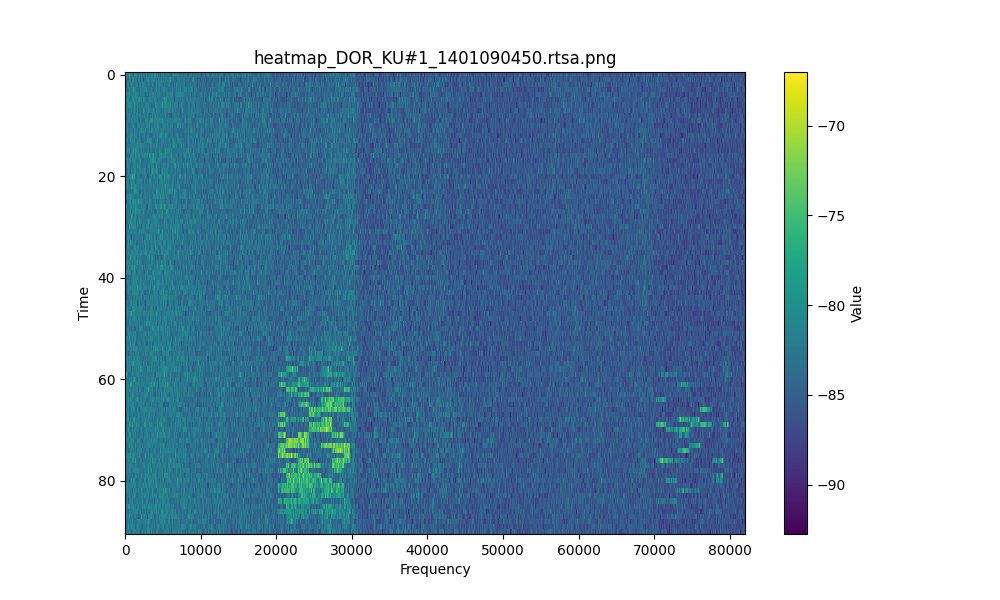

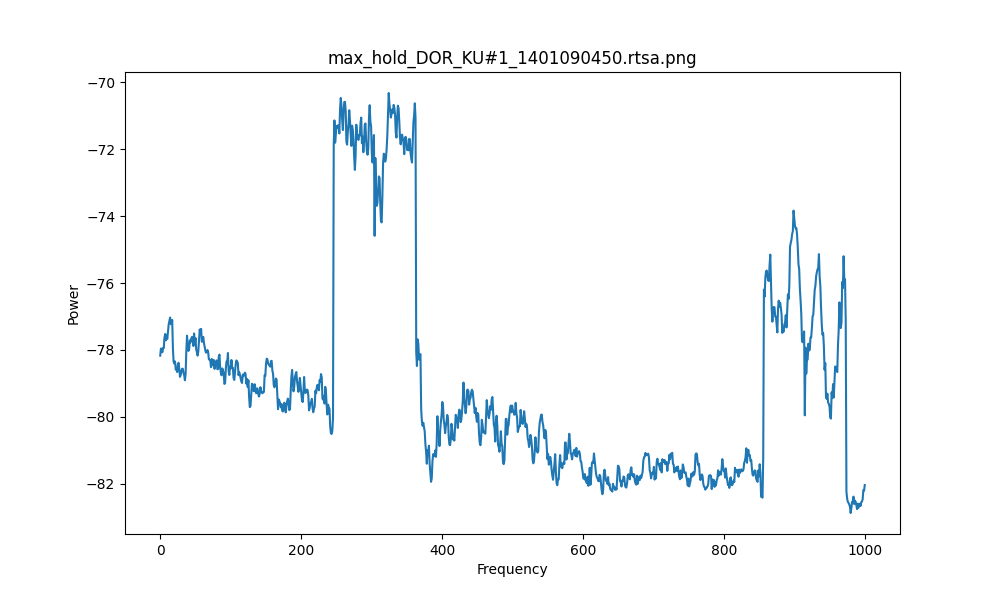

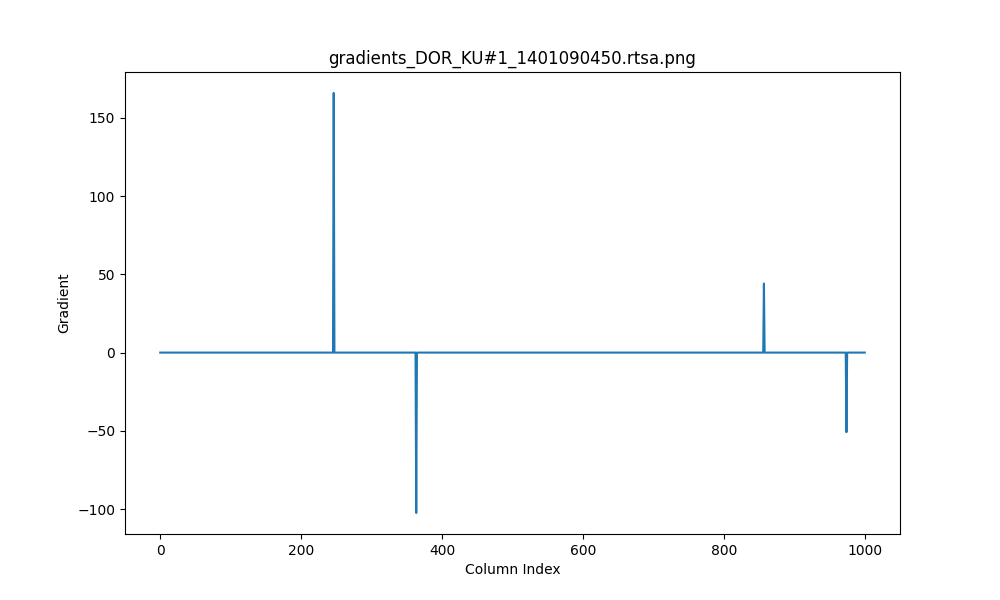

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of sam

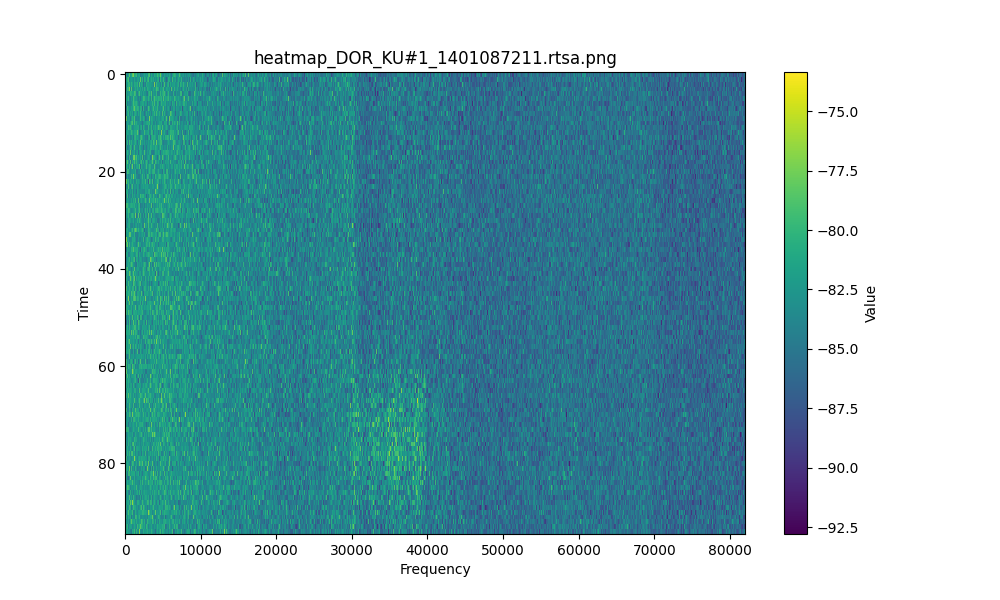

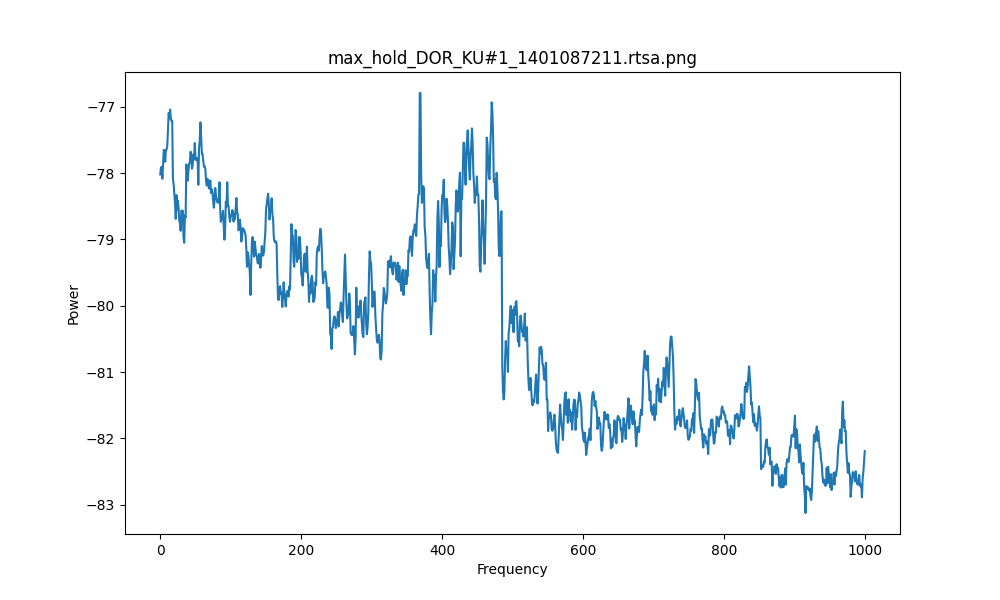

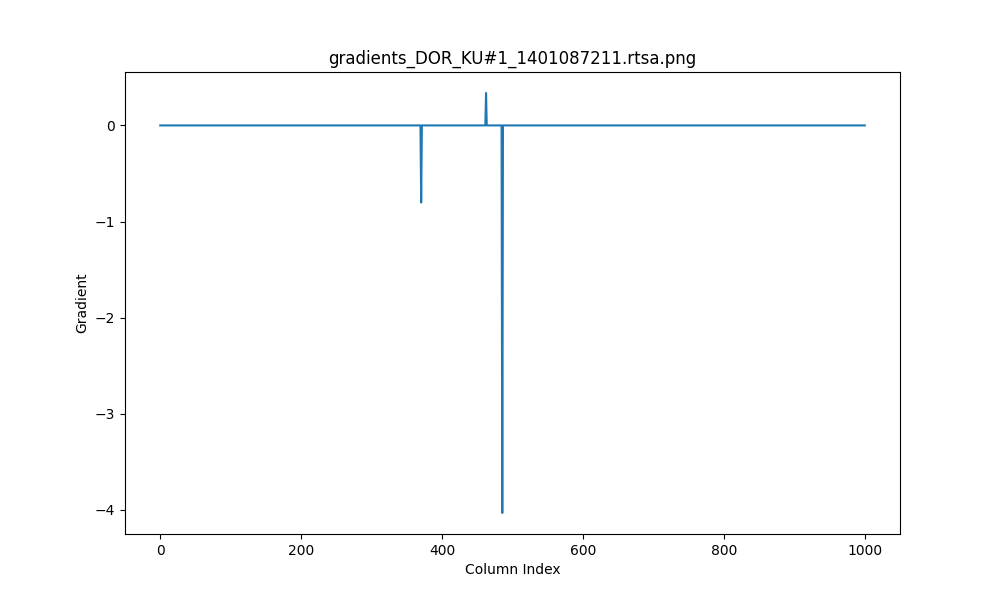

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0


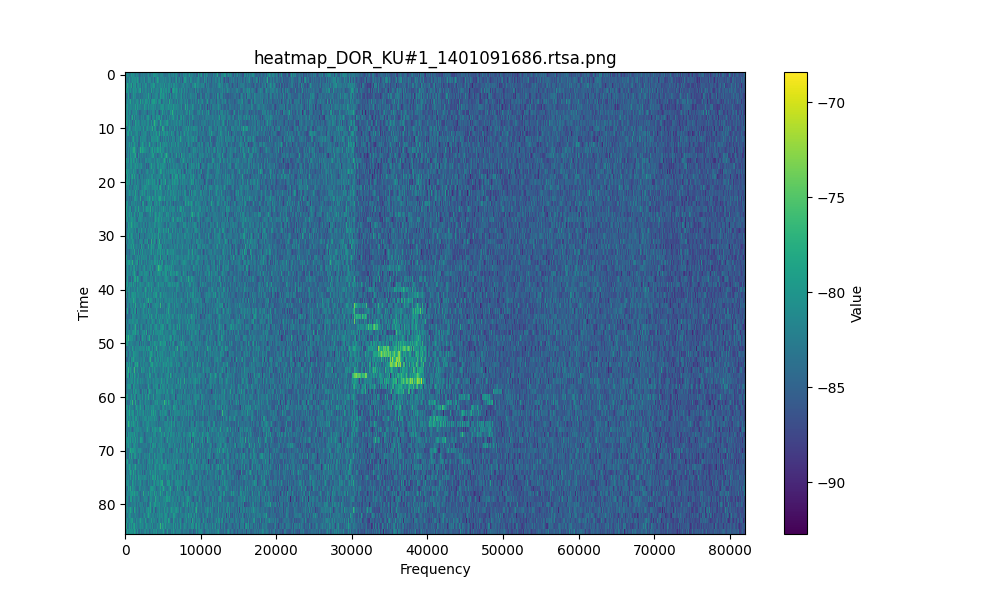

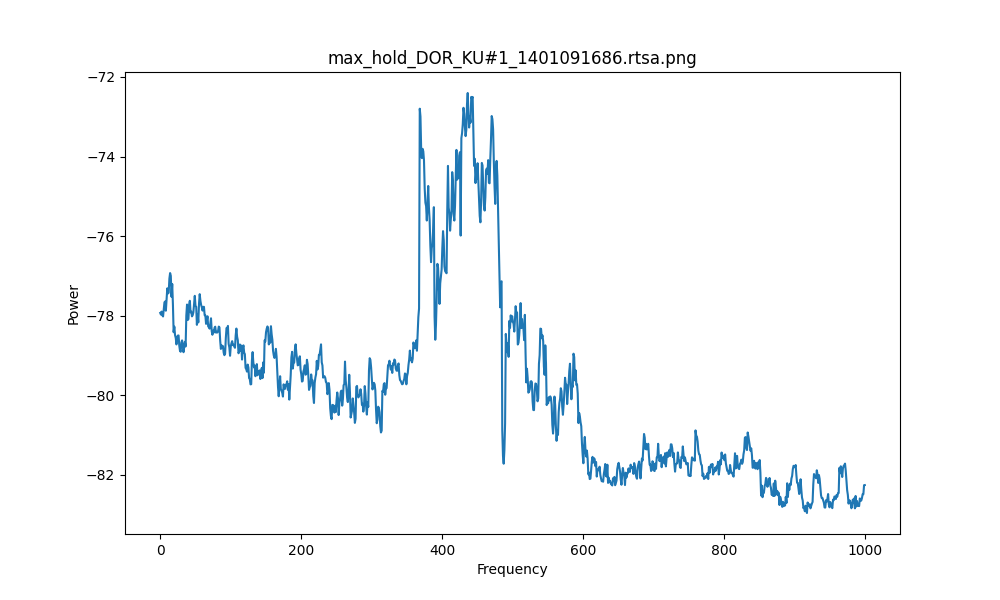

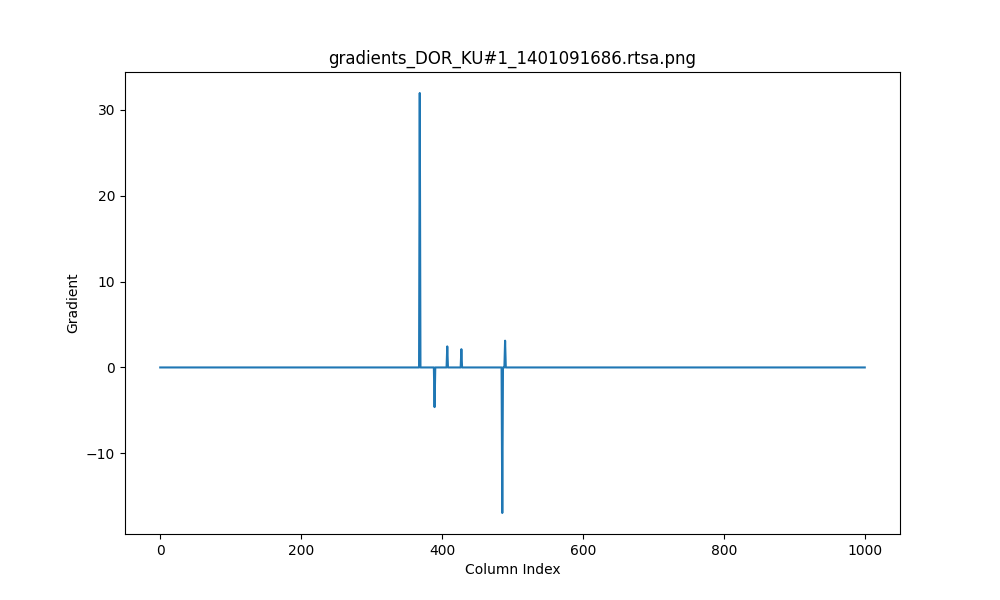

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 6970000
get_samples_array: Number of sweeps: 85.0


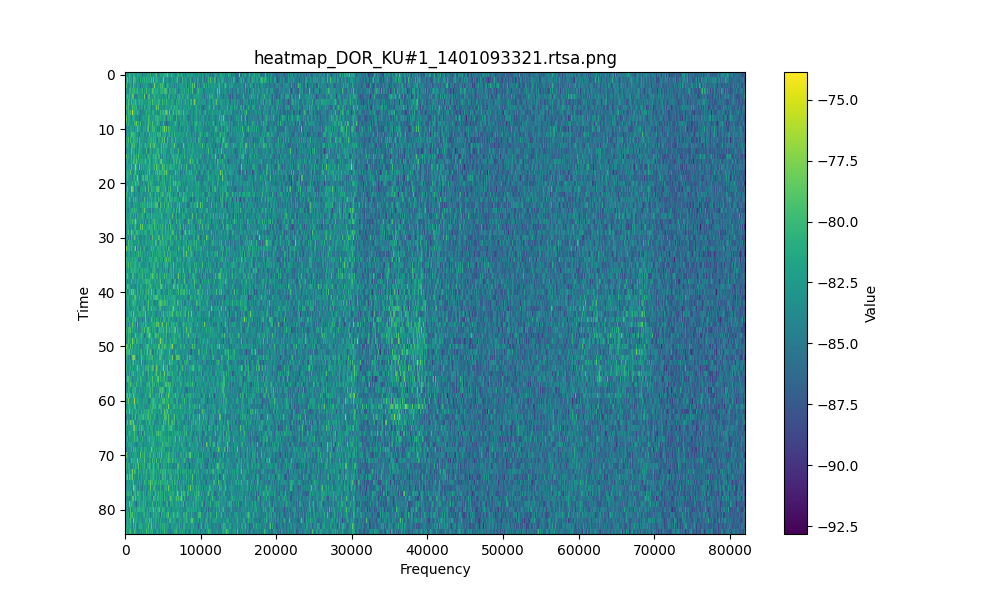

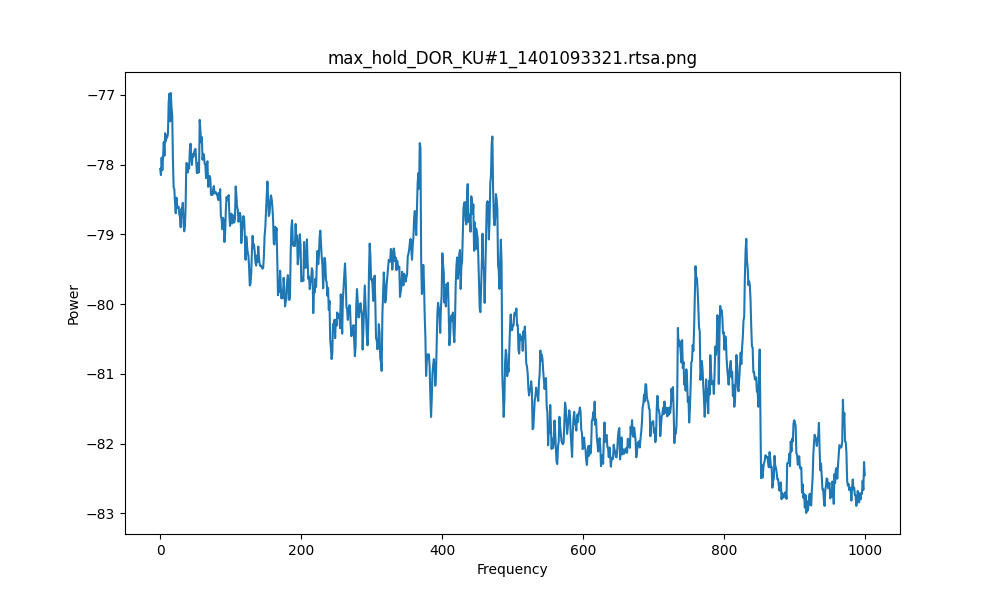

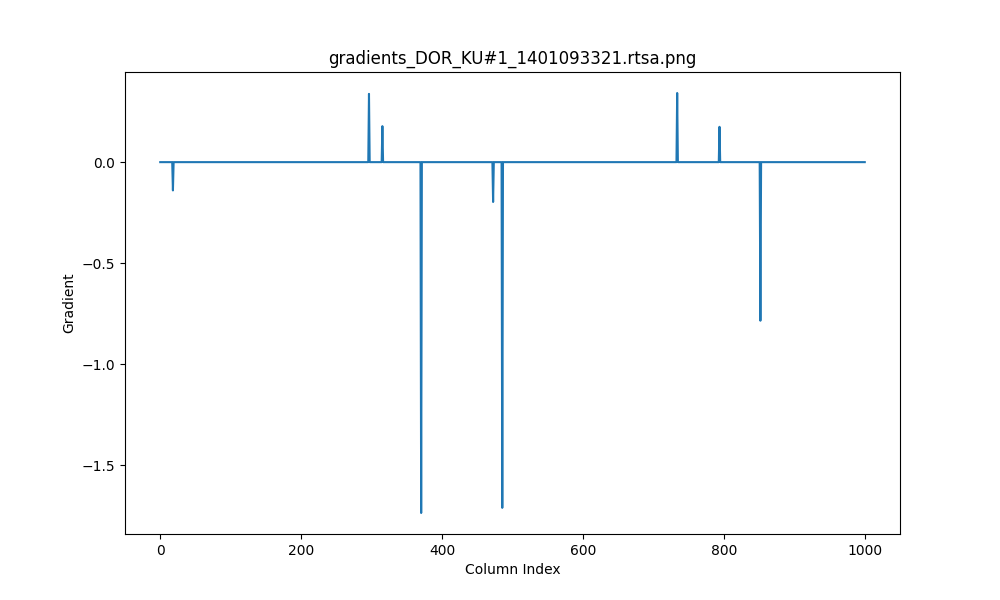

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of sam

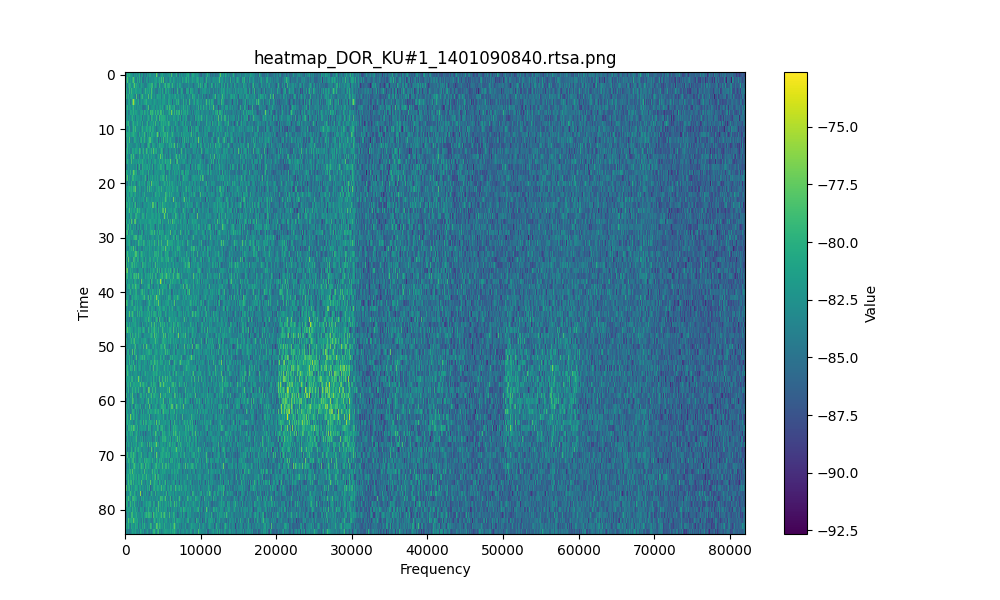

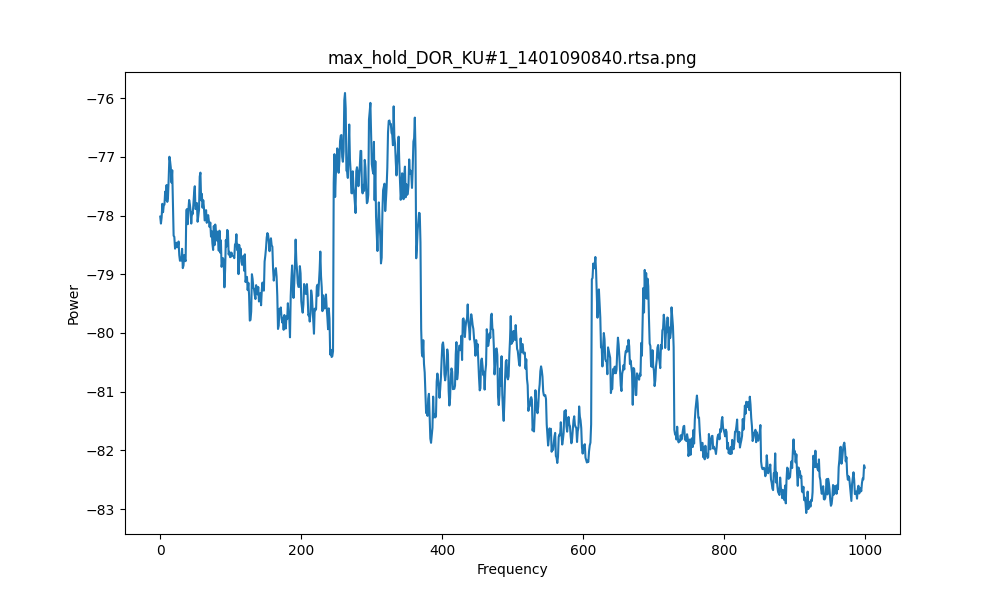

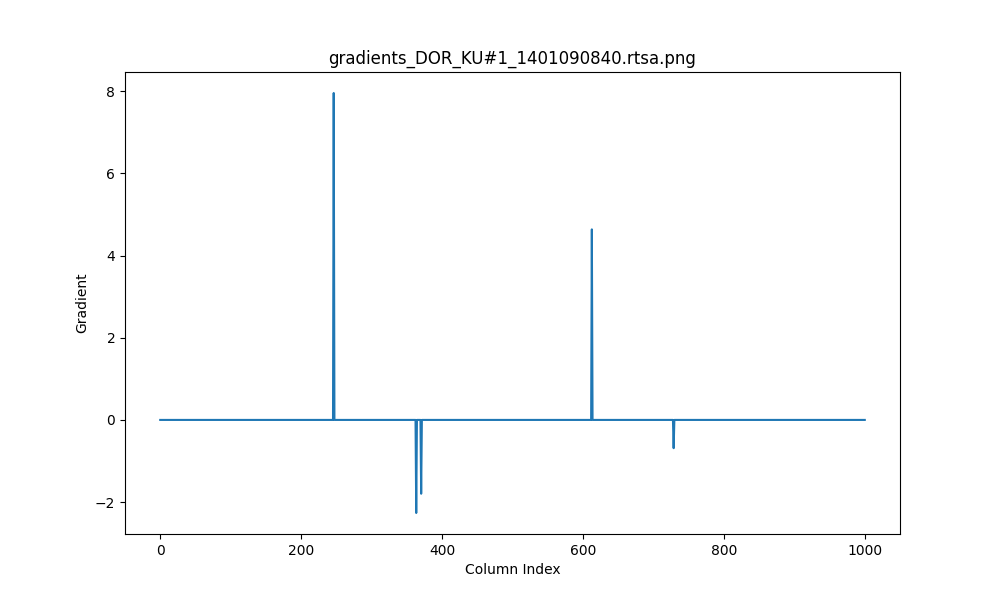

get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of samples: 6806000
get_samples_array: Number of sweeps: 83.0
get_samples_array: Number of samples: 7626000
get_samples_array: Number of sweeps: 93.0
get_samples_array: Number of samples: 3772000
get_samples_array: Number of sweeps: 46.0
get_samples_array: Number of samples: 7872000
get_samples_array: Number of sweeps: 96.0
get_samples_array: Number of samples: 7052000
get_samples_array: Number of sweeps: 86.0
get_samples_array: Number of samples: 7790000
get_samples_array: Number of sweeps: 95.0
get_samples_array: Number of sam

In [12]:
if __name__ == "__main__":            

    multiple_std = 2

    for file in carriers_samples:
            file_path = os.path.join('Files_for_SW_Dev_application', file)
            if os.path.isfile(file_path):
                # Load samples from file
                with open(file_path, "rb") as file_object:
                    samples = get_samples_from_file(file_object)

                # Extract time information
                start_time = samples.start_time
                end_time = samples.end_time
                time_span = end_time - start_time
                time_steps = len(samples.samples)
            
                # Generate and plot heatmap
                heatmap_bytes = get_heatmap_png(samples)
                matrix = samples.samples
                plot_heatmap(matrix, f'heatmap_{file}.png')

                # Preprocessing: flatten matrix to 1D array and take the max power value from each column and downsample the array
                max_hold = np.amax(matrix, axis=0)
                downsampled_max_hold = max_hold.reshape(-1, len(max_hold) // 1000).mean(axis=1)
                plot_max_hold(downsampled_max_hold, f'max_hold_{file}.png')
            
                # Calculate gradients and apply a threshold calculated from the mean and std_deviation of the gradients array
                gradients = np.gradient(downsampled_max_hold)
                gradients = gradients**3
                std = np.std(gradients)
                threshold = multiple_std * std 
                gradients[np.abs(gradients) < threshold] = 0
                gradients = smooth(gradients)
                plot_gradients(gradients, f'gradients_{file}.png')
                
                carrier_info_list = []

                # Detect carriers and gather information
                for index, carrier in enumerate(detect_carriers(gradients)):
                    start_index, end_index = carrier

                    # Adjust indices for downsampling (thesubtraction of 41 from the indices corrects for the approximate 0.5 index rightward shift introduced during smoothing, adjusted for the downsampling factor of 82)
                    start_index = start_index * 82 - 41
                    end_index = end_index * 82 - 41

                    noise_samples_threshold = noise_threshold(noise_samples, multiple_std)
                    start_time_index, end_time_index, max_power = get_time_and_max_power(int(start_index), int(end_index), matrix, noise_samples_threshold)

                    time_step = time_span / time_steps
                    time_start = float(start_time + start_time_index * time_step)
                    time_end = float(end_time + end_time_index * time_step)

                    # Adjust frequency indices
                    start_index = float(start_index * 0.025)
                    end_index = float(end_index * 0.025)

                    carrier_info = {
                        "contact": file,
                        "car_num": index+1,
                        "frq_start": start_index + 10410,
                        "frq_end": end_index + 10410,
                        "time_start": time_start,
                        "time_end": time_end,
                        "max_power": float(max_power),
                    }
                    carrier_info_list.append(carrier_info)

                # Write the carrier information to a JSON file
                json_file_path = os.path.join(carrier_dir, f'{file}.json')
                with open(json_file_path, 'w') as json_file:
                    json.dump(carrier_info_list, json_file, indent=4)


                

                    